# 王子老师课件1.17问题(Armington模型)的计算

在国家n上消费者效用最大化问题的拉格朗日方程：  
$\max_{C_{in}, L_n}\left[\sum_{i=1}^{N}C_{in}^{\frac{\sigma-1}{\sigma}}\right]^{\frac{\sigma}{\sigma-1}}-\frac{L_n^{1+\eta}}{1+\eta} + \lambda_n\left(w_nL_n - \sum_{i=1}^{N}P_{in}C_{in}\right)$  
一阶条件如下：  
$\left[\sum_{i=1}^{N}C_{in}^{\frac{\sigma-1}{\sigma}}\right]^{\frac{1}{\sigma-1}}C_{in}^{-\frac{1}{\sigma}} = \lambda_{n}P_{in} \Rightarrow \left[\sum_{i=1}^{N}C_{in}^{\frac{\sigma-1}{\sigma}}\right]^{-1}C_{in}^{\frac{\sigma-1}{\sigma}} = \lambda_{n}^{1-\sigma}P_{in}^{1-\sigma} \Rightarrow \lambda_n = \frac{1}{P_n}$  
其中价格指数$P_n = \left[\sum_{i=1}^{N}P_{in}^{1-\sigma}\right]^{\frac{1}{1-\sigma}}$，实际工资水平$L_n^\eta = \lambda_nw_n$  

在均衡时，国家i的总成本（工资支出）=国家i的总收益（国家i卖给其他国家的产品销售额）： 
$w_iL_i = \sum_{i=1}^{N}\frac{w_i^{1-\sigma}\left(\frac{\tau_{in}}{A_i}\right)^{1-\sigma}}{P_n^{1-\sigma}}w_nL_n \Rightarrow w_i\left(\frac{w_i}{P_i}\right)^{\frac{1}{\eta}}= \sum_{i=1}^{N}\frac{w_i^{1-\sigma}\left(\frac{\tau_{in}}{A_i}\right)^{1-\sigma}}{P_n^{1-\sigma}}w_n\left(\frac{w_n}{P_n}\right)^{\frac{1}{\eta}}$  
其中，$P_n = \left[\sum_{i=1}^{N}w_i^{1-\sigma}\left(\frac{\tau_{in}}{A_i}\right)^{1-\sigma}\right]^{\frac{1}{1-\sigma}}$  

均衡时的效用水平：$U_{i}=\frac{\eta}{1+\eta}\left(\frac{w_{i}}{P_{i}}\right)^{\frac{1+\eta}{\eta}}$


下面计算习题1.15中三个国家模型的情况

In [1]:
cd(homedir())

In [2]:
] activate lecture-source-jl/source/rst/Project.toml

 Activating environment at `~/lecture-source-jl/source/rst/Project.toml`


In [3]:
using Parameters
using LinearAlgebra, Statistics, Compat
using NLsolve,Plots,BenchmarkTools

## baseline

In [4]:
#将已知条件放入结构m中，方便后面进行调用
E = Matrix{Float64}(I, 3, 3);
mdef = @with_kw (N = 3,sigma = 4,eta = 2,A = [3;2;1],tau = 2*(1 .- E)+E)
m = mdef() 

(N = 3, sigma = 4, eta = 2, A = [3, 2, 1], tau = [1.0 2.0 2.0; 2.0 1.0 2.0; 2.0 2.0 1.0])

## Equilibrium computation

In [5]:
function update_eqm(w,m)
    #w和m.A都是N维（这里假设是3维）列向量，点除之后得到各个国家w和A的比值。
    #再将此N维列向量复制N次，得到N*N的矩阵，并且a_i1 = a_i2 = ……=a_in=wi/Ai。
    #repeat得到的N*N的矩阵，与tau进行点乘（注意，不是相乘，是点乘）。
    P_mat = repeat((w./m.A).^(1-m.sigma),1,m.N).*m.tau.^float((1-m.sigma)); 
    #将得到的P_mat的元素纵向相加（也就是把各个国家加总到一起）得到一个1*N的行向量，再转置为列向量。
    P = (sum(P_mat,dims=1)').^(1/(1-m.sigma));
    #根据公式计算实际工资水平L（一个列向量）。
    L = (w./P).^(1/m.eta);
    #
    w_new = sum(P_mat.*repeat((P').^(m.sigma-1).*(w.*L)',m.N,1),dims=2)./L;
    return (w_new,P,L)
end

update_eqm (generic function with 1 method)

In [6]:
w = ones(m.N,1);#初始猜想，后面对w进行更新
ww = 0.1;
cc = 1;#统计迭代次数
tol = 1e-6;
diff = 1;

In [7]:
w_new, P, L = update_eqm(w, m)#测试方程能否正常运行

([1.6893899351166863; 0.9008186721810948; 0.20424112607226128], [0.328828276577396; 0.4430309359830305; 0.5708743241637889], [1.7438752816032173; 1.5023910002848795; 1.3235176727922306])

In [8]:
while diff > tol && cc < 500
    w_new, P, L = update_eqm(w, m)
    diff = norm(w_new-w)
    println(diff)
    println(cc)
    #不能直接将产生的w_new赋给w（w = w_new)，需要将产生的w_new进行线性组合，赋给w；
    #再将新的w中的元素求平方和，用w除以此平方和，将w限制在单位圆中，以此得到解析解。
    w = ww*w_new + (1-ww)*w
    wn = w'*w
    w = w/wn

    cc = cc+1
end

1.057510096340859
1
0.28243175767533457
2
0.6766015289640255
3
0.18323247074176555
4
0.44109626486593234
5
0.1195312380175982
6
0.2872354617448504
7
0.07757304001566301
8
0.1855901181449418
9
0.0498814709644734
10
0.11878693051829102
11
0.03179948088107831
12
0.07549963084732958
13
0.020174463665286208
14
0.047870496526082405
15
0.012799197553447574
16
0.03042105698513933
17
0.0081548634743345
18
0.01944749458354526
19
0.0052337586328519495
20
0.012535681190976613
21
0.003389207706973534
22
0.00815617327073346
23
0.002215612672331673
24
0.005356739606190196
25
0.0014616872810519887
26
0.0035490391660855354
27
0.0009722991094867923
28
0.0023695500411080967
29
0.0006513788700463158
30
0.0015923787463219972
31
0.00043896654052703047
32
0.0010758137620876609
33
0.0002972335338052455
34
0.0007299111357734866
35
0.0002020211457227442
36
0.0004968711232756401
37
0.00013770916151634432
38
0.0003391001950614146
39
9.40804750498525e-5
40
0.00023187754395366774
41
6.438320709163095e-5
42
0.000158

In [9]:
welfare = m.eta/(1+m.eta)*(w./P).^((1+m.eta)/m.eta);
println([w,P,L,welfare])#输出求出的解析解

[[1.3133222365155155; 0.96379770345869; 0.571123712167417], [0.1402214251042865; 0.15045274786668306; 0.16796691399984934], [1.7728717874115878; 1.4661952501013615; 1.068198902400013], [19.109271127591914; 10.809046508239838; 4.1799242738113715]]


## 比较静态

Welfare gains from trade liberalization。让m.tau逐渐变小。

In [10]:
tt_vec = (2:-0.1:1)';#贸易冰山成本的参数变化：从2降到1，步长为0.1
T = length(tt_vec);#一共进行T步
welfare_mat = ones(m.N, T);#预先把welfare和L放到N*T的矩阵当中，预先都先设定为1，后面会进行替换
L_mat = ones(m.N, T);

In [11]:
println([tt_vec,T,welfare_mat,L_mat])

Any[[2.0 1.9 1.8 1.7 1.6 1.5 1.4 1.3 1.2 1.1 1.0], 11, [1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0; 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0; 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0], [1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0; 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0; 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0]]


In [12]:
for t in 1:T 
    m = mdef(tau = tt_vec[t]*(1 .-E) + E)#每次对m进行更新
    
    w = ones(m.N,1); # Initial guess
    ww = 0.1;
    cc = 1;
    tol = 1e-6;
    diff = 1;#除了tau以外，其他的baseline不变。
    
    while diff > tol && cc < 500
        w_new, P, L = update_eqm(w, m);#调用了更新后的m
        diff = norm(w_new-w);
                
        w = ww*w_new + (1-ww)*w;
        wn = w'*w;
        w = w/wn;
        
        cc = cc+1;
    end
    
    println(diff)
    println(cc)#给定m，算出解析解的迭代次数是否超过了开始时设定的500次，如果大于或等于了500次，就要提高求解的最大的迭代次数
    println(t)
    
    welfare_mat[:,t] = m.eta/(1 .+m.eta)*(w./P).^((1 .+m.eta)/m.eta);#一共有N行T列，每计算一次，对 welfare_mat的第t列进行替换
    L_mat[:,t] = L;

end

7.111881283502499e-7
67
1
8.964223648379845e-7
59
2
8.676679019314167e-7
53
3
9.836829567854168e-7
47
4
7.488464942818193e-7
43
5
6.535978954220709e-7
39
6
7.160322778029478e-7
35
7
4.4901273063354986e-7
33
8
3.7953435414965455e-7
31
9
4.6302372032009885e-7
29
10
7.645578863256355e-7
27
11


In [13]:
welfare_mat = welfare_mat'#转置后，每一个列向量表示一个国家的福利变化

11×3 Adjoint{Float64,Array{Float64,2}}:
 19.1093  10.809   4.17992
 19.3137  10.9879  4.30291
 19.561   11.2059  4.45349
 19.8622  11.4738  4.63949
 20.2314  11.8061  4.87137
 20.6877  12.2225  5.16331
 21.2564  12.7505  5.53462
 21.9723  13.4287  6.01194
 22.8834  14.3128  6.63226
 24.0584  15.4841  7.4476
 25.5974  17.0649  8.53246

In [14]:
#计算welfare_mat相对初始时期的变化，要使welfare_mat的每一行除以第一行。
#将welfare_mat的第一行提取后，是一个列向量，转置为行向量后，再按行复制T（这里是11）次。
re = repeat(welfare_mat[1,:]',T,1) 

11×3 Array{Float64,2}:
 19.1093  10.809  4.17992
 19.1093  10.809  4.17992
 19.1093  10.809  4.17992
 19.1093  10.809  4.17992
 19.1093  10.809  4.17992
 19.1093  10.809  4.17992
 19.1093  10.809  4.17992
 19.1093  10.809  4.17992
 19.1093  10.809  4.17992
 19.1093  10.809  4.17992
 19.1093  10.809  4.17992

In [15]:
#点除
welfare_mat = welfare_mat ./ re

11×3 Array{Float64,2}:
 1.0      1.0      1.0
 1.0107   1.01655  1.02942
 1.02364  1.03671  1.06545
 1.0394   1.0615   1.10995
 1.05872  1.09224  1.16542
 1.0826   1.13077  1.23526
 1.11236  1.17962  1.3241
 1.14982  1.24236  1.43829
 1.1975   1.32415  1.58669
 1.25899  1.43251  1.78176
 1.33953  1.57876  2.04129

In [16]:
L_mat = L_mat'

11×3 Adjoint{Float64,Array{Float64,2}}:
 1.77287  1.4662   1.0682
 1.7789   1.47401  1.07841
 1.78609  1.48339  1.09062
 1.79474  1.49472  1.10531
 1.80519  1.50851  1.12305
 1.8179   1.52541  1.14457
 1.83346  1.54627  1.17077
 1.85265  1.57222  1.20274
 1.87648  1.60476  1.24182
 1.90635  1.64592  1.28959
 1.94416  1.69838  1.34801

画图

In [17]:
x = tt_vec'

2.0:-0.1:1.0

In [18]:
welfare_mat[:,1]#观察第一列（country 1）的福利变化

11-element Array{Float64,1}:
 1.0
 1.010697569346818
 1.0236409528402886
 1.039400160401348
 1.058722739036654
 1.0825995881512562
 1.11236144072476
 1.1498228614272918
 1.1975043146861915
 1.2589896243445964
 1.3395252359405747

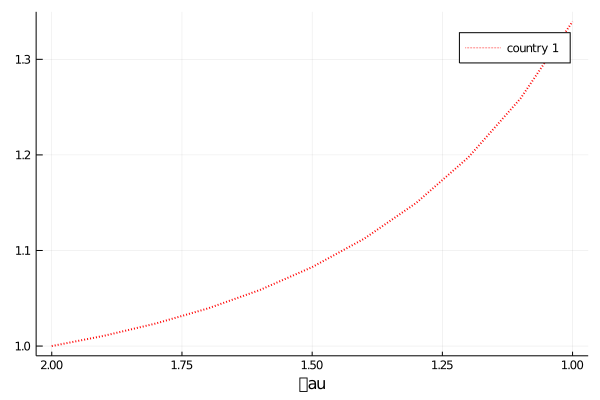

In [19]:
#尝试画出country 1的变化。注意调用xflip属性，使x轴从大到小变化。
Plots.plot(x,welfare_mat[:,1],color=:red, linewidth=2, label="country 1",linestyle=:dot, xflip=true,xlabel="\tau")

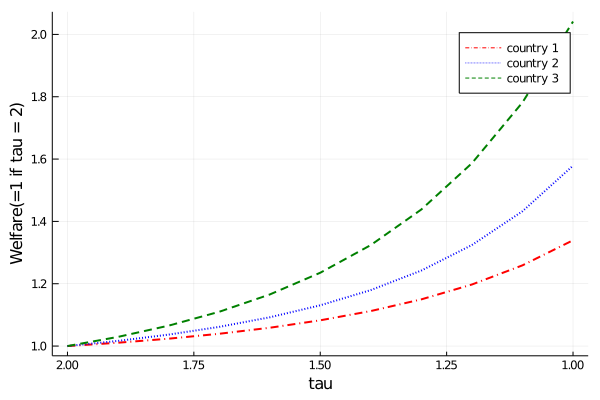

In [20]:
Plots.plot(x,welfare_mat,linewidth=2, xflip=true,
    label=["country 1"  "country 2" "country 3"],
    xlabel="tau", ylabel="Welfare(=1 if tau = 2)",
    linestyle=[:dashdot :dot :dash],
    linecolor=[:red :blue :green])

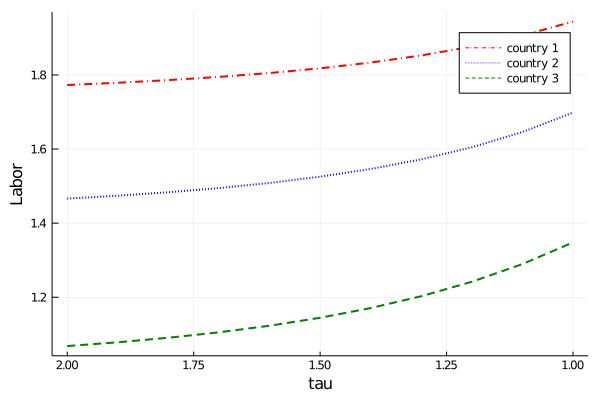

In [21]:
Plots.plot(x,L_mat,linewidth=2, xflip=true,
    label=["country 1"  "country 2" "country 3"],
    xlabel="tau", ylabel="Labor",
    linestyle=[:dashdot :dot :dash],
    linecolor=[:red :blue :green])